#### Q1 - Train and validate an n-layer Neural Network on apparel dataset to predict the class label of a given apparel.


In [0]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import io
eps = np.finfo(float).eps

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### read data

In [0]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/apparel-trainval.csv')

#### split data into train and test set.

In [0]:
data = shuffle(data).reset_index(drop=True)
index = int(0.8 * len(data))
data_train = data[:index]
data_test = data[index:]

#### helper functions

In [0]:
def one_hot_encode(Y, unique_labels):
    y_mat = np.zeros((Y.shape[0], len(unique_labels)))
    for i in range(len(Y)):
        y_mat[i][Y[i]] = 1
    return y_mat

def activation_func(function_name):
    fun = ""
    del_fun = ""
    if function_name == "relu":
        fun = relu
        del_fun = delta_relu
        
    elif function_name == "tanh":
        fun = tan_h
        del_fun = delta_tan_h
        
    elif function_name == "sigmoid":
        fun = sigmoid
        del_fun = delta_sigmoid
    return fun, del_fun

def sigmoid(x):
    return 1. / (1. + np.exp(-x))
  
def delta_sigmoid(x):
    sig = sigmoid(x)
    return sig * (1. - sig)
  
def softmax(x):
    shift_x = x - np.array([np.max(x, axis=1)]).T
    exps = np.exp(shift_x)
    return exps / np.array([np.sum(exps, axis=1)]).T
    
def delta_softmax(x):
    soft = softmax(x)
    return soft * (1. - soft)

def tan_h(x):
    return np.tanh(x)
  
def delta_tan_h(x):
    return 1.0 - np.tanh(x)**2

def relu(x):
    return np.maximum(x, 0.0, x) 
  
def delta_relu(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x
  
def delta_mean_square_error(y_, y):
    return (y_ - y)
  
def cross_entropy(predictions, targets, epsilon = 1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets * np.log(predictions + 1e-9))/N
    return ce

# def user_input():
#     layers = int(input("Enter the number of hidden layers: "))
#     neurons = []
#     for i in range(layers):
#         print("Enter the number of neurons in layer ", i, ": ")
#         temp = input()
#         neurons.append(int(temp))
#     batch_size = int(input("Enter the batch size: "))
#     epochs = int(input("Enter the number of epochs: "))
#     return layers, neurons, batch_size, epochs
  
def save_weights(best_weights):
    np.save('/content/gdrive/My Drive/Colab Notebooks/best_weights.npy', best_weights)
    
def load_weights():
    loaded_weights = np.load('/content/gdrive/My Drive/Colab Notebooks/best_weights.npy')
    return loaded_weights
  
def model_acc(model):
    test_x = data_test.iloc[:,1:]
    test_x = StandardScaler().fit_transform(test_x)
    
    predicted_y = model.test(test_x)
    predicted_y = np.argmax(predicted_y, axis=1)
    return accuracy_score(data_test.iloc[:,0], predicted_y)

In [0]:
X = data_train.iloc[:,1:]
X = StandardScaler().fit_transform(X)

Y = data_train.iloc[:,0]

unique_labels = np.unique(Y).tolist() 
Y = one_hot_encode(Y, unique_labels)

#### Neural Network class

In [0]:
class NeuralNetwork:
    def __init__(self,layers, neurons, output_labels, features, batch_size, epochs, function_name, load_from_file, alpha=0.00001):
        if load_from_file == 1:
            self.weights = load_weights()
        else:
            self.weights = np.empty(layers + 1, dtype = object)

        for i in range(len(self.weights)):
            if i == layers:
                _range =  np.sqrt(1. / neurons[i - 1])
                self.weights[i] = np.random.uniform(-_range,_range,(neurons[i - 1], len(output_labels)))
            elif i == 0:
                _range =  np.sqrt(1. / features)
                self.weights[i] = np.random.uniform(-_range,_range,(features, neurons[i])) 
            else:
                _range =  np.sqrt(1. / neurons[i - 1])
                self.weights[i] =  np.random.uniform(-_range,_range,(neurons[i-1], neurons[i]))
        
        
        self.fun, self.delta_fun = activation_func(function_name)
        
        self.alpha = alpha
        self.layers = layers
        self.batch_size = batch_size
        self.epochs = epochs
        self.output_labels = output_labels

    def back_prop(self,X, y):
        delta_weights = np.empty(layers + 1, dtype = object)
        for i in range(len(self.weights) - 1, -1, -1): 
          if i == self.layers:
              delta_weights[i] = np.multiply(delta_mean_square_error(self.h_out[-1], y), delta_softmax(self.h_in[-1]))
          else: 
              delta_weights[i] = np.multiply(np.dot(delta_weights[i+1], self.weights[i+1].T), self.delta_fun(self.h_in[i]))

        for i in range(layers + 1):
            if i == 0:
                self.weights[i] -= self.alpha * np.dot(X.T, delta_weights[i])
            else:
                self.weights[i] -= self.alpha * np.dot(self.h_out[i-1].T, delta_weights[i])
    
    def feed_forward(self,X):
        self.h_in = np.empty(layers + 1, dtype = object)
        self.h_out = np.empty(layers + 1, dtype = object)
        for i in range(len(self.weights)):
            if i == self.layers:
                self.h_in[i] = np.dot(self.h_out[i - 1], self.weights[i])
                self.h_out[i] = softmax(self.h_in[i])
            elif i == 0:
                self.h_in[i] = np.dot(X, self.weights[i])
                self.h_out[i] = self.fun(self.h_in[i])
            else:
                self.h_in[i] = np.dot(self.h_out[i - 1], self.weights[i])
                self.h_out[i] = self.fun(self.h_in[i])                      
                
    def train(self,X, y):
        all_costs = []
        for i in range(self.epochs):
            cost = 0
            for j in range(0, X.shape[0], self.batch_size):
                X_batch = X[j:j+self.batch_size]   
                Y_batch = y[j:j+self.batch_size]
                self.feed_forward(X_batch)
                self.back_prop(X_batch, Y_batch)
                cost += cross_entropy(self.h_out[-1], Y_batch)
            if i%10 == 1:    
                print(i,cost / self.batch_size)
            all_costs.append(cost / self.batch_size)
        return all_costs
            
    def test(self,test_x):
        self.feed_forward(test_x)
        y_ = self.h_out[-1]
        return y_
                

#### calling neural network with all 3 activation functions

In [13]:
# functions = ['sigmoid', 'tanh', 'relu']

neurons = [100]
layers = len(neurons)
batch_size = 500
epochs = 500
# lr_dic = {'sigmoid':0.001,"tanh":0.00001,"relu":0.000001}
features = 784
best_weights = 0
best_acc = 0
cost_dic = {}
best_fun = 0

# running for sigmoid
model = NeuralNetwork(layers, neurons, unique_labels, features, batch_size, epochs, "sigmoid", 0, 0.001)
cost = model.train(X, Y)

accuracy = model_acc(model)
if accuracy > best_acc:
    best_acc = accuracy
    best_fun = 'sigmoid'
    save_weights(model.weights)

print("Sigmoid acccuracy is",accuracy, "cost is",cost)
cost_dic['sigmoid'] = cost


# running for tanh
model = NeuralNetwork(layers, neurons, unique_labels, features, batch_size, epochs, "tanh", 0, 0.00001)
cost = model.train(X, Y)

accuracy = model_acc(model)
if accuracy > best_acc:
    best_acc = accuracy
    best_fun = 'tanh'
    save_weights(model.weights)
    
print("Tanh, acccuracy is",accuracy, "cost is",cost)
cost_dic['tanh'] = cost


# running for relu
model = NeuralNetwork(layers, neurons, unique_labels, features, batch_size, epochs, "relu", 0, 0.000001)
cost = model.train(X, Y)

accuracy = model_acc(model)
if accuracy > best_acc:
    best_acc = accuracy
    best_fun = 'relu'
    save_weights(model.weights)

print("Relu, acccuracy is",accuracy, "cost is",cost)
cost_dic['relu'] = cost


(1, 0.15332576147747315)
(11, 0.08986631441809424)
(21, 0.07954285641773486)
(31, 0.07405548561501811)
(41, 0.0702819494196591)
(51, 0.06736964519517878)
(61, 0.0649909750497204)
(71, 0.0629824769146845)
(81, 0.0612212641073412)
(91, 0.059623698149485885)
(101, 0.05815686184266558)
(111, 0.056803487895675596)
(121, 0.055559674078321734)
(131, 0.054417181773735716)
(141, 0.053372393241896285)
(151, 0.052398666537587714)
(161, 0.05147450262435329)
(171, 0.05059997901927139)
(181, 0.049752811975780055)
(191, 0.048937784844069694)
(201, 0.048154010847911904)
(211, 0.047396870912805006)
(221, 0.046667623545383376)
(231, 0.04597405441127638)
(241, 0.045315046497022615)
(251, 0.04468488930053898)
(261, 0.04407980995299723)
(271, 0.04349566303741946)
(281, 0.04292844931551797)
(291, 0.04237448661292589)
(301, 0.04184356263433706)
(311, 0.04133391699965945)
(321, 0.04084699916715526)
(331, 0.040380228411745274)
(341, 0.03993019345917042)
(351, 0.03949384843947375)
(361, 0.03906906619640456)
(37

#### plotting

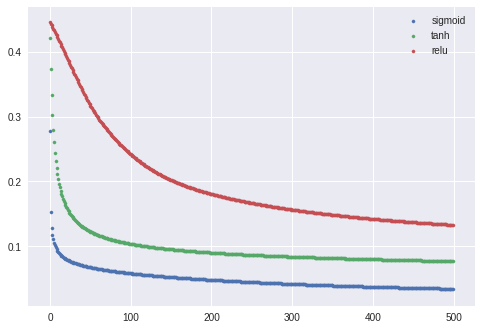

In [14]:
activation_funs = ['sigmoid', 'tanh', 'relu']
fig = plt.figure()
ax1 = fig.add_subplot(111)
x_axis = [i for i in range(epochs)]

for f in activation_funs:
    ax1.scatter(x_axis, cost_dic[f], s = 10, label=f)

plt.legend()
plt.show()  

#### prediction of test data

In [0]:
best_fun = 'sigmoid'
from numpy import savetxt
def final_test():
    test_filename = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/apparel-test.csv')
    model = NeuralNetwork(layers, neurons, unique_labels, features, batch_size, epochs, best_fun, 1, 0.001)
    pred = model.test(test_filename)
    pred = np.argmax(pred, axis = 1)
    savetxt('/content/gdrive/My Drive/Colab Notebooks/2018201103_prediction.csv', pred, fmt = "%d")
    
final_test()